Ссылка на датасет: https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset

Я не очень понял, можно ли использовать датасет из "kaggle". Но мне достаточно 7 баллов за данную работу

In [33]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("misrakahmed/vegetable-image-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/misrakahmed/vegetable-image-dataset/versions/1


In [34]:
!ls '/root/.cache/kagglehub/datasets/misrakahmed/vegetable-image-dataset/versions/1/Vegetable Images'

test  train  validation


In [35]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

image_size = 224

train_dataset = ImageFolder('/root/.cache/kagglehub/datasets/misrakahmed/vegetable-image-dataset/versions/1/Vegetable Images/train',
                      transform = transforms.Compose([
                      transforms.Resize((image_size, image_size)),
                      transforms.ToTensor()
                    ]))

test_dataset = ImageFolder('/root/.cache/kagglehub/datasets/misrakahmed/vegetable-image-dataset/versions/1/Vegetable Images/test',
                      transform = transforms.Compose([
                      transforms.Resize((image_size, image_size)),
                      transforms.ToTensor()
                    ]))

In [36]:
img, _ = train_dataset[0]
img.shape

torch.Size([3, 224, 224])

In [37]:
train_dataset.classes, len(train_dataset.classes)

(['Bean',
  'Bitter_Gourd',
  'Bottle_Gourd',
  'Brinjal',
  'Broccoli',
  'Cabbage',
  'Capsicum',
  'Carrot',
  'Cauliflower',
  'Cucumber',
  'Papaya',
  'Potato',
  'Pumpkin',
  'Radish',
  'Tomato'],
 15)

In [38]:
from torch.utils.data.dataloader import DataLoader

batch_size = 16

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

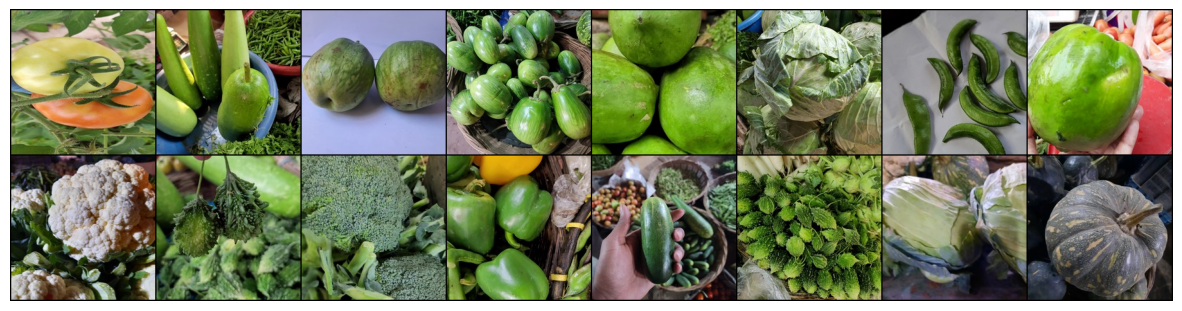

In [39]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt


for images, labels in train_dataloader:
  fig, ax = plt.subplots(figsize = (15, 15))
  plt.axis("off")
  ax.imshow(make_grid(images).permute(1, 2, 0))
  break

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [63]:
import torch.nn as nn

class ImageClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ImageClassifier, self).__init__()

        self.features = nn.Sequential(
          nn.Conv2d(3, 32, kernel_size=5, stride=2, padding=3),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Conv2d(128, 512, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(512),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        embeddings = self.global_avg_pool(x).squeeze(-1).squeeze(-1)
        x = self.classifier(embeddings)
        return x, embeddings

In [64]:
import torch.optim as optim

model = ImageClassifier(num_classes = 15).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [65]:
import time

def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    count_correct = 0

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs, _ = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()

        total_loss += loss.item()

        loss.backward()
        optimizer.step()

        _, predicted = outputs.max(1)
        count_correct += predicted.eq(labels).sum().item()

    acc = 100 * count_correct / len(dataloader.dataset)
    avg_loss = total_loss / len(dataloader)
    return avg_loss, acc

def test(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    count_correct = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs, _ = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            count_correct += predicted.eq(labels).sum().item()

    acc = 100 * count_correct / len(dataloader.dataset)
    avg_loss = total_loss / len(dataloader)
    return avg_loss, acc

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

epochs = 10
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()

    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    test_loss, test_acc = test(model, test_dataloader, criterion, device)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    epoch_end_time = time.time()
    print(f'Эпоха - {epoch}')
    print(f'\tВремя на эпоху - {(epoch_end_time - epoch_start_time):.2f} s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}%')
    print(f'\t Test Loss: {test_loss:.3f} |  Test Acc: {test_acc:.2f}%')
    print()

Эпоха - 1
	Время на эпоху - 36.39 s
	Train Loss: 1.364 | Train Acc: 59.52%
	 Test Loss: 0.811 |  Test Acc: 76.33%

Эпоха - 2
	Время на эпоху - 36.62 s
	Train Loss: 0.670 | Train Acc: 80.22%
	 Test Loss: 0.338 |  Test Acc: 90.67%

Эпоха - 3
	Время на эпоху - 36.33 s
	Train Loss: 0.470 | Train Acc: 86.61%
	 Test Loss: 0.255 |  Test Acc: 93.03%

Эпоха - 4
	Время на эпоху - 37.02 s
	Train Loss: 0.363 | Train Acc: 89.41%
	 Test Loss: 0.174 |  Test Acc: 95.37%

Эпоха - 5
	Время на эпоху - 36.45 s
	Train Loss: 0.297 | Train Acc: 91.43%
	 Test Loss: 0.137 |  Test Acc: 96.10%

Эпоха - 6
	Время на эпоху - 35.16 s
	Train Loss: 0.240 | Train Acc: 93.13%
	 Test Loss: 0.111 |  Test Acc: 96.90%

Эпоха - 7
	Время на эпоху - 36.16 s
	Train Loss: 0.211 | Train Acc: 93.63%
	 Test Loss: 0.178 |  Test Acc: 94.40%

Эпоха - 8
	Время на эпоху - 36.07 s
	Train Loss: 0.181 | Train Acc: 94.65%
	 Test Loss: 0.145 |  Test Acc: 95.23%

Эпоха - 9
	Время на эпоху - 36.40 s
	Train Loss: 0.156 | Train Acc: 95.61%
	 Tes

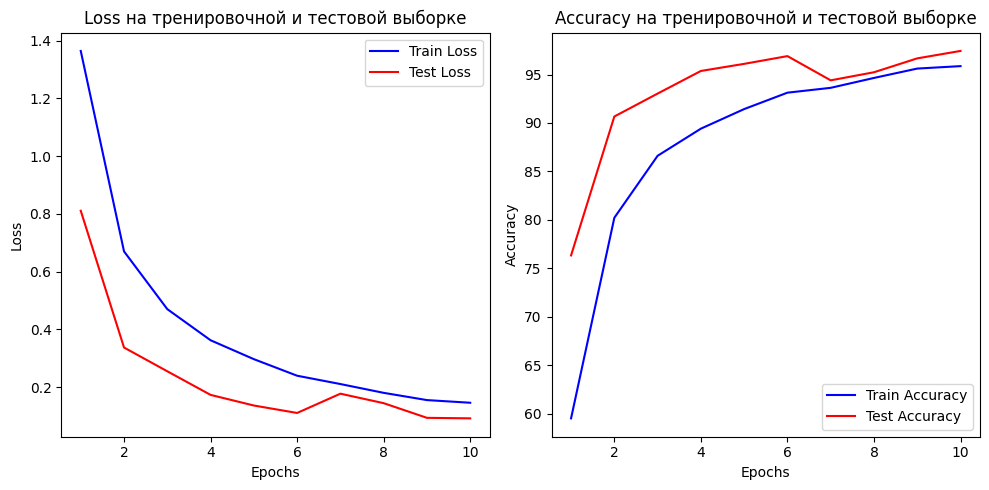

In [66]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss на тренировочной и тестовой выборке')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy на тренировочной и тестовой выборке')
plt.legend()

plt.tight_layout()
plt.show()

In [67]:
import numpy as np

embeddings = []
labels = []

model.eval()
with torch.no_grad():
    for images, targets in test_dataloader:
        images = images.to(device)
        targets = targets.to(device)

        _, global_embeddings = model(images)
        embeddings.append(global_embeddings.cpu().numpy())
        labels.append(targets.cpu().numpy())

embeddings = np.vstack(embeddings)
labels = np.concatenate(labels)


In [68]:
embeddings.shape

(3000, 512)

In [69]:
labels.shape

(3000,)

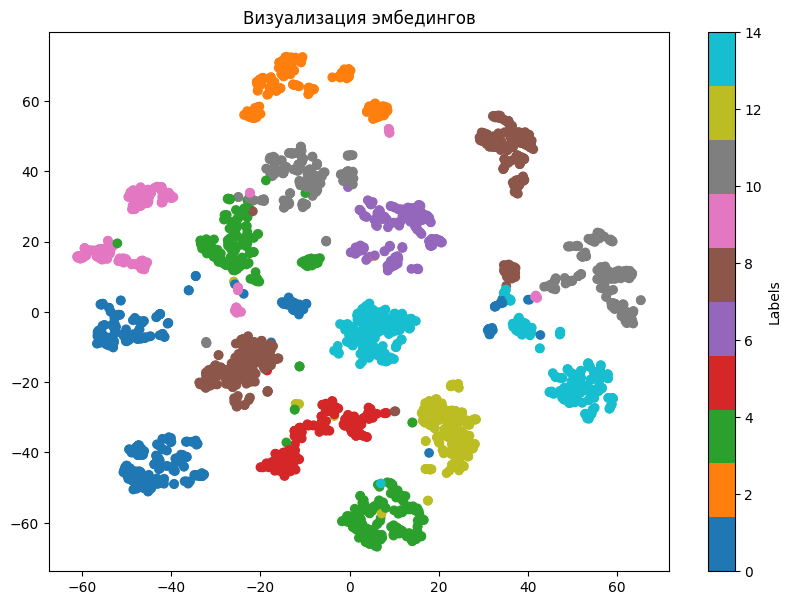

In [70]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='tab10')
plt.colorbar(scatter, label='Labels')
plt.title("Визуализация эмбедингов")
plt.show()

In [71]:
from torchvision import models
from torchvision.models import ResNet18_Weights

class TransferLearningModel(nn.Module):
    def __init__(self, num_classes):
        super(TransferLearningModel, self).__init__()

        self.backbone = models.resnet18(weights=ResNet18_Weights.DEFAULT)

        for param in self.backbone.parameters():
            param.requires_grad = False

        in_features = self.backbone.fc.in_features

        self.backbone.fc = nn.Identity()
        self.classifier = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        features = self.backbone(x)
        output = self.classifier(features)

        return output, features

In [72]:
model = TransferLearningModel(15).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [73]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

epochs = 10
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()

    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    test_loss, test_acc = test(model, test_dataloader, criterion, device)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    epoch_end_time = time.time()
    print(f'Эпоха - {epoch}')
    print(f'\tВремя на эпоху - {(epoch_end_time - epoch_start_time):.2f} s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}%')
    print(f'\t Test Loss: {test_loss:.3f} |  Test Acc: {test_acc:.2f}%')
    print()

Эпоха - 1
	Время на эпоху - 42.80 s
	Train Loss: 1.208 | Train Acc: 74.77%
	 Test Loss: 0.278 |  Test Acc: 97.07%

Эпоха - 2
	Время на эпоху - 42.19 s
	Train Loss: 0.331 | Train Acc: 93.71%
	 Test Loss: 0.106 |  Test Acc: 98.33%

Эпоха - 3
	Время на эпоху - 42.25 s
	Train Loss: 0.196 | Train Acc: 95.81%
	 Test Loss: 0.062 |  Test Acc: 99.07%

Эпоха - 4
	Время на эпоху - 42.04 s
	Train Loss: 0.136 | Train Acc: 96.96%
	 Test Loss: 0.048 |  Test Acc: 99.13%

Эпоха - 5
	Время на эпоху - 40.80 s
	Train Loss: 0.117 | Train Acc: 97.28%
	 Test Loss: 0.036 |  Test Acc: 99.27%

Эпоха - 6
	Время на эпоху - 40.48 s
	Train Loss: 0.091 | Train Acc: 97.93%
	 Test Loss: 0.030 |  Test Acc: 99.43%

Эпоха - 7
	Время на эпоху - 40.62 s
	Train Loss: 0.077 | Train Acc: 98.04%
	 Test Loss: 0.025 |  Test Acc: 99.47%

Эпоха - 8
	Время на эпоху - 40.81 s
	Train Loss: 0.071 | Train Acc: 98.23%
	 Test Loss: 0.021 |  Test Acc: 99.67%

Эпоха - 9
	Время на эпоху - 41.33 s
	Train Loss: 0.065 | Train Acc: 98.29%
	 Tes

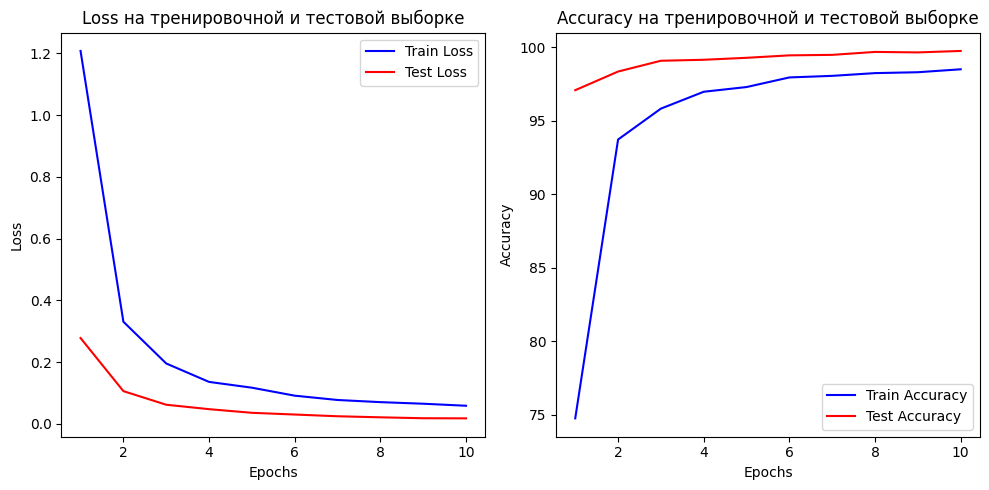

In [74]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss на тренировочной и тестовой выборке')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy на тренировочной и тестовой выборке')
plt.legend()

plt.tight_layout()
plt.show()

In [75]:
import numpy as np

embeddings = []
labels = []

model.eval()
with torch.no_grad():
    for images, targets in test_dataloader:
        images = images.to(device)
        targets = targets.to(device)

        _, global_embeddings = model(images)
        embeddings.append(global_embeddings.cpu().numpy())
        labels.append(targets.cpu().numpy())

embeddings = np.vstack(embeddings)
labels = np.concatenate(labels)


In [76]:
embeddings.shape

(3000, 512)

In [77]:
labels.shape

(3000,)

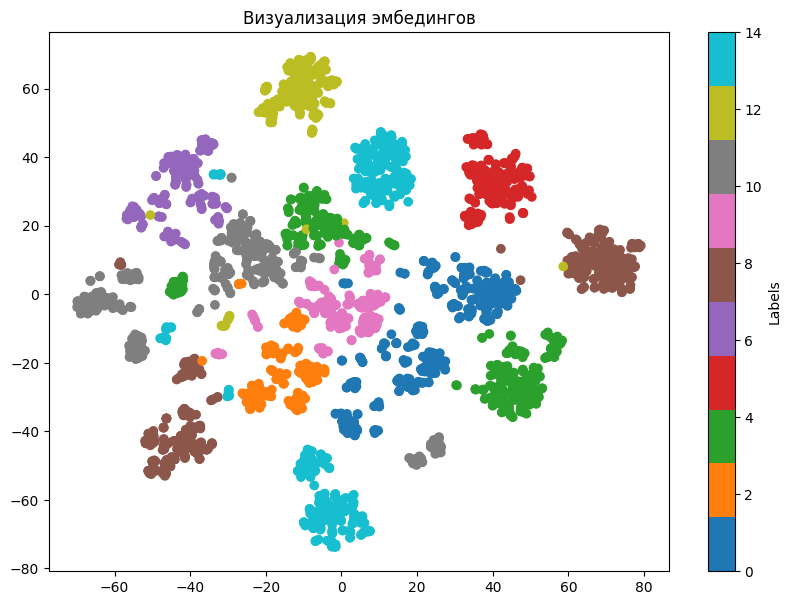

In [78]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='tab10')
plt.colorbar(scatter, label='Labels')
plt.title("Визуализация эмбедингов")
plt.show()

Две модели обучаются приблизительно одинаковое время, но вторая модель имеет более стабильные и лучшиие показатели